# Grasp Detection

### Comp 341

### Imports

In [ ]:
import os
import numpy as np 
from numpy import cos, sin
import matplotlib.pyplot as plt
import multiprocessing
import time

from visualisation import draw_box, cv2_imshow
from rect_metric import compare_grasps, grasp_accuracy, visul_grasps

%matplotlib inline

import seaborn as sns
sns.set()

## Progress bar
from tqdm.std import tqdm, trange
from tqdm import notebook

notebook.tqdm = tqdm
notebook.trange = trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torch.optim as optim
torch.backends.cudnn.benchmark = True 

import torchvision as tv


print("Using torch", torch.__version__)

Using torch 1.11.0+cu102


In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

In [ ]:
# Fetching the device that will be used throughout this notebook

try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_PATH = "drive/MyDrive/Liverpool/Assignments/Year 3/COMP341/COMP341 - Assignment 01 - Data/Data/"
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
    !pip install shapely
except:
    print('not in drive')
    DATASET_PATH = 'ass1_data/Data'
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:1")
print("Using device", device)

not in drive
Using device cpu


### Load Dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class GraspDataset(Dataset):
  def __init__(self, root_dir, transforms=None, depth_image=None):
      self.root_dir = root_dir
      self.depth_image = {'perfect':'pDepth', 'stereo': 'sDepth'}.get(depth_image)
      self.transforms = transforms if transforms else tv.transforms.Compose([tv.transforms.ToTensor()])

      # List of all scenes for all objects in the dataset
      self.scene_paths = []
      for object_name in os.listdir(root_dir):
        for scene_index in range(5): # Scene index ranges from 0 to 4 for all objects

          scene_root = f"{root_dir}/{object_name}/{scene_index}_{object_name}_"

          # Make sure a scene with this index exists for this object
          grasp_path = scene_root + "grasps.txt"
          if not os.path.exists(grasp_path): continue

          # Add scene files and appened to the list
          scene = {
              "grasps": grasp_path,
              "rgb": scene_root + "RGB.png",
              "mask": scene_root + "mask.png",
              "pDepth": scene_root + "perfect_depth.tiff",
              "sDepth": scene_root + "stereo_depth.tiff"
          }
          self.scene_paths.append(scene)

  # This must return the length of the dataset
  def __len__(self):
    return len(self.scene_paths)

  # This must return the single dataset item at index idx
  def __getitem__(self, idx):

    # Load the grasps
    grasps = []
    with open(self.scene_paths[idx]["grasps"]) as file:
      lines = file.readlines()
      for line in lines:
        x, y, theta, openning, jaw_size = [float(number) for number in line.split(";")]
        grasp = [x, y, theta, openning, jaw_size]
        grasps.append(grasp)
    grasps = np.array(grasps, dtype=np.float32)

    # Load the RGB image
    image = Image.open(self.scene_paths[idx]["rgb"])

    if self.transforms: #do transforms
        image = self.transforms(image)

    if self.depth_image is not None:
      depth = Image.open(self.scene_paths[idx][self.depth_image])
      return (image, depth, grasps[0])

    return (image, grasps[0])

### Lets look at an image

In [ ]:
# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    npimg = np.transpose(npimg, (1, 2, 0))
    
    plt.imshow(npimg)

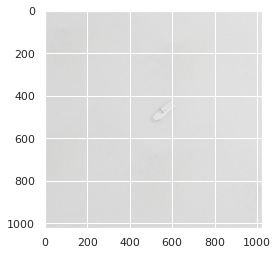

In [ ]:
# Show off the dataset
index = 4

dataset = GraspDataset(DATASET_PATH + "/training")
loader = td.DataLoader(dataset, batch_size=4, shuffle=False, drop_last=False, num_workers=2)
batch = next(iter(loader))
imshow(batch[0][index%4])


# print("grasp:", batch[2][index])
# print("depth:", batch[1][index])



## Boilerplate Code

### helpers

In [ ]:
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_epochs(train_history, validation_history=None, plotType="loss"):
    x = np.arange(1, len(train_history) + 1)
    plt.figure(figsize=(8, 6))
    if validation_history:
        plt.plot(x, val_history, color=colors[1], label=f"Validation {plotType}", linewidth=2)
    plt.plot(x, train_history, color=colors[0], label=f"Training {plotType}", linewidth=2)
    plt.ylabel(f'{plotType}')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title(f"Evolution of the training and validation {plotType}")
    plt.show()

In [ ]:
def get_cnn_output_size(in_size, kernel_size, stride=1, padding=0):
    integer = int((in_size - kernel_size + 2 * padding) / stride) == ((in_size - kernel_size + 2 * padding) / stride)
    if not integer:
        print("not int", ((in_size - kernel_size + 2 * padding) / stride))
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

In [ ]:
get_cnn_output_size(64, kernel_size=3, stride=2, padding=0)

not int 30.5


31

### loss and optimisers

In [ ]:
def getLoss():
    return nn.MSELoss()

def getOptimiser(model, learningRate):
    #optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimiser = optim.Adam(model.parameters(), lr=learningRate)
    return optimiser

### Data Loaders

In [ ]:
def gen_transforms(resize=None, imgs_mean=(0.5,), imgs_std=(0.5,)):
    tst_trans = [tv.transforms.ToTensor()]
    if resize is not None:
        tst_trans.append(tv.transforms.Resize(resize[0]))
        tst_trans.append(tv.transforms.CenterCrop(resize[1]))
    tst_trans.append(tv.transforms.Normalize(mean=imgs_mean, std=imgs_std))
    return tv.transforms.Compose(tst_trans)

def get_train_loader(batchSize, resize = None):
    transforms = gen_transforms(resize)
    trainData = GraspDataset(root_dir=f'{DATASET_PATH}/training', transforms=transforms)
    trainLoader = td.DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=False, num_workers=2)
    return trainLoader

### Training function

In [ ]:
def train(model, batch_size, n_epochs, learning_rate, resize=None):
    print(f"batch size: {batch_size}")
    print(f"n epochs: {n_epochs}")
    print(f"learning rate: {learning_rate}")
    print("="*20)
    
    trainLoader = get_train_loader(batch_size, resize)
    lossFn = getLoss()
    optimizer = getOptimiser(model, learning_rate)

    train_history = []
    accuracy_history = []
    training_start_time = time.time()
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)

    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss = 0
        epoch_accuracy = 0
        
        with tqdm(trainLoader, unit="batch") as tepoch:
            for rgb, grasp in tepoch:   #for each batch
                tepoch.set_description(f"Epoch {epoch}")
                # Move tensors to gpu
                rgb, grasp = rgb.to(device), grasp.to(device)
               
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(rgb)
                # _, predicted = outputs.argmax(dim=1, keepdim=True).squeeze()
                #  = torch.max(outputs, 1)
                # print('out', outputs.size(), 'targets', grasps.size())
                # g = torch.FloatTensor(grasp.cpu().numpy()).to(device)
                loss = lossFn(outputs,  grasp)
                loss.backward()
                optimizer.step()
                # add to running totals
                epoch_loss += loss.item()
                with torch.no_grad():
                    accs = grasp_accuracy(outputs.cpu().numpy(), grasp.cpu().numpy())
                    epoch_accuracy += accs
        epoch_loss = epoch_loss / len(trainLoader)
        # print(f"Epoch #{epoch + 1} train_loss: {round(epoch_loss,2)} accuracy: {round(epoch_accuracy,1)}% took: {round(time.time() - start_time,2)}s") 
        train_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy/len(trainLoader))
        
    print(f"Training Finished, took {round(time.time() - training_start_time,1)}s")
    return train_history, accuracy_history

## Our Models

In [ ]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()

        # Input image is size 1024x1024
        self.conv1 = nn.Conv2d(3, 64, kernel_size=6, stride=2, padding=0) # output is 510x510
        #torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchN = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # output is 255x255
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # output is 128x128
        #torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchN2 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # output is 64x64
        
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0) # output is 128x128
        #torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchN2 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(508032, 5)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchN(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchN2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # flatten tensor
        x = x.view(x.size()[0], -1)

        x = self.fc1(x)

        return x

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, depth_in, activation_func, depth_out=-1):
        super().__init__()
        if depth_out == -1:
            depth_out = depth_in
        else:
            self.downSampleResidul = True

        self.resBlock = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(),
            nn.Conv2d(depth_in, depth_out, kernel_size=3, padding=1, stride=1 if not self.downSampleResidul else 2, bias=False),
            nn.BatchNorm2d(depth_out),
            activation_func(),
            nn.Conv2d(depth_out, depth_out, kernel_size=3, padding=1, bias=False)
        )

        self.downsampleRes = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(),
            nn.Conv2d(depth_in, depth_out, kernel_size=1, stride=2, bias=False)
        )

    def forward(self, x):
        z = self.resBlock(x)
        if self.downSampleResidul:
            x = self.downsampleRes(x)
        return z + x

In [ ]:
class DeepConvNN(nn.Module):
    def __init__(self):
        super(DeepConvNN, self).__init__()
        #in = 1024 x 1024
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=0), #out = 511x511
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 509x509
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 507x507
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(kernel_size=3, stride=2, padding=0) #out = 253x253
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 253x253
        )

        self.block2 = ResNetBlock(32, nn.SiLU, 64)      #out = 127x127
        self.block3 = ResNetBlock(64, nn.SiLU, 128)     #out = 64x64
        self.block4 = ResNetBlock(128, nn.SiLU, 256)    #out = 32x32
        self.block5 = ResNetBlock(256, nn.SiLU, 256)    #out = 16x16

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.flattened_size = 256 * 8 * 8 #36864

        self.regressionBlock = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flattened_size, 512),
            nn.Dropout(0.2),
            nn.Linear(512, 5),
            
            # nn.Linear(2048, 5)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        x = self.regressionBlock(x)
        return x

In [ ]:
network = 'DeepConv' # choices are 'DeepConv' or 'Conv'

if network == 'DeepConv':
  resize = None # (1047, 1047)
  BATCH_SIZE = 4
  EPOCHS = 8
  LEARNING_RATE = 0.001
  nnet = DeepConvNN()
elif network == 'Conv':
  resize = None
  BATCH_SIZE = 4
  EPOCHS = 8
  LEARNING_RATE = 0.001
  nnet = ConvNN()

train_loss, train_acc = train(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE, resize=resize)

batch size: 4
n epochs: 8
learning rate: 0.001
Epoch 7: 100%|██████████| 8/8 [00:23<00:00,  2.95s/batch]Training Finished, took 191.9s



### loss and accuracy plots

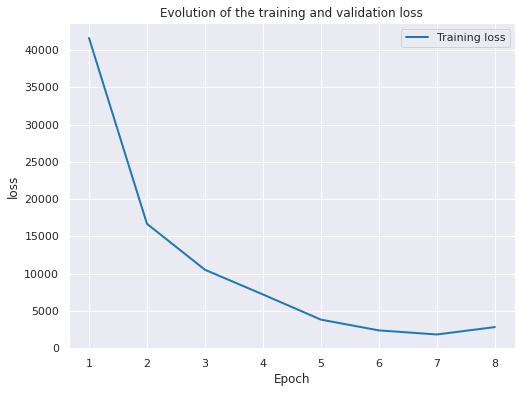

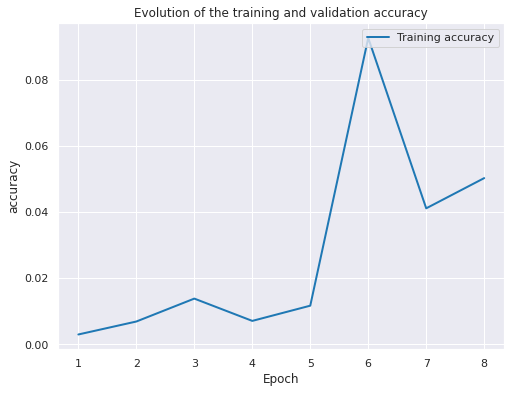

In [ ]:
plot_epochs(train_loss)
plot_epochs(train_acc, plotType="accuracy")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=adefdfa6-d6a9-4c68-83ce-d8488efeaa89' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>